
# How Elon Musk's tweets affect stock prices?


# Application setup

First of all, let's setup authentication to Twitter API.


In [5]:

import numpy
import tweepy
import pandas
import SECRETS
import re
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [6]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(SECRETS.API_KEY, SECRETS.API_SECRET_KEY)
auth.set_access_token(SECRETS.ACCESS_TOKEN, SECRETS.ACCESS_SECRET_TOKEN)

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print('Authentication OK')
except:
    print('Error during authentication')


Authentication OK



Everything seems fine, we can proceed to download data.

5 latest tweets:


In [7]:

musk_tweets = api.user_timeline(screen_name='elonmusk',
                                count=5,
                                tweet_mode='extended'
                                )

for tweet in musk_tweets:
     print('------------')
     print("ID: {}".format(tweet.id))
     print(tweet.created_at)
     print(tweet.full_text)


------------
ID: 1397456432681811969
2021-05-26 07:35:51
@Caspar_Stanley @Erdayastronaut @SpaceX @SuperHeavyBN3 Yup
------------
ID: 1397348509309829121
2021-05-26 00:27:00
@Astro_Elliott @Teslarati @ResidentSponge Aiming to have hot gas thrusters on booster for first orbital flight
------------
ID: 1397348226806665220
2021-05-26 00:25:53
@IlyaRosenberg @Caspar_Stanley @Erdayastronaut @SpaceX @SuperHeavyBN3 They are now the same (LOX below CH4). Ox is 3.5 times heavier than fuel, so makes sense to have it lower.
------------
ID: 1397347380874203136
2021-05-26 00:22:31
@Teslarati @ResidentSponge Pure vision Autopilot is now rolling out in North America. There will be an update of this production release in 2 weeks, then FSD beta V9.0 (also pure vision) a week later. FSD subscription will be enabled around the same time.
------------
ID: 1397345464475807745
2021-05-26 00:14:54
@Teslarati @13ericralph31 Exactly 🤣🤣



# Downloading tweets

We will download at least 5000 tweets to have reasonable data set.
It is worth mentioning here that the maximum allowed .user_timeline(count=) is 200.


In [8]:

downloaded_tweets = []
last_id = musk_tweets[-1].id

while len(downloaded_tweets)<5000:
    musk_tweets = api.user_timeline(screen_name='elonmusk',
                               count=200,
                               include_rts = False,
                               max_id = last_id - 1,
                               tweet_mode = 'extended'
                               )
    downloaded_tweets.extend(musk_tweets)
    # if len(musk_tweets) == 0:
    #     break
    if len(musk_tweets) != 0:
        last_id = musk_tweets[-1].id
        downloaded_tweets.extend(musk_tweets)
    print('N of tweets downloaded till now {}'.format(len(downloaded_tweets)))

print(len(downloaded_tweets))


N of tweets downloaded till now 0
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 90
N of tweets downloaded till now 452
N of tweets downloaded till now 452
N of tweets downloaded till now 452
N of tweets downloaded till now 840
N of tweets downloaded till now 840
N of tweets downloaded till now 1224
N of tweets downloaded till now 1224
N of tweets downloaded till now 1608
N of tweets downloaded till now 1608
N of tweets downloaded till now 1982
N of tweets downloaded till now 1982
N of tweets downloaded till now 2374
N of tweets downloaded till now 2740
N of tweets downloaded till now 2740
N of tweets downloaded till now 2740
N of tweets downloaded till now 2740
N of tweets downloaded till n


# Reviewing data


In [9]:

words_in_tweets = {}

for tweet in downloaded_tweets:

    # using regular expression to be exclude all "@#!.?"
    t_words = re.findall(r'\w+', tweet.full_text)

    # adding words counting
    for word in t_words:
        if word in words_in_tweets:
            words_in_tweets[word] += 1
        else:
            words_in_tweets[word] = 1

words_to_work_with = words_in_tweets.copy()



We have dictionary {'word' : times_used}


Let's plot some words


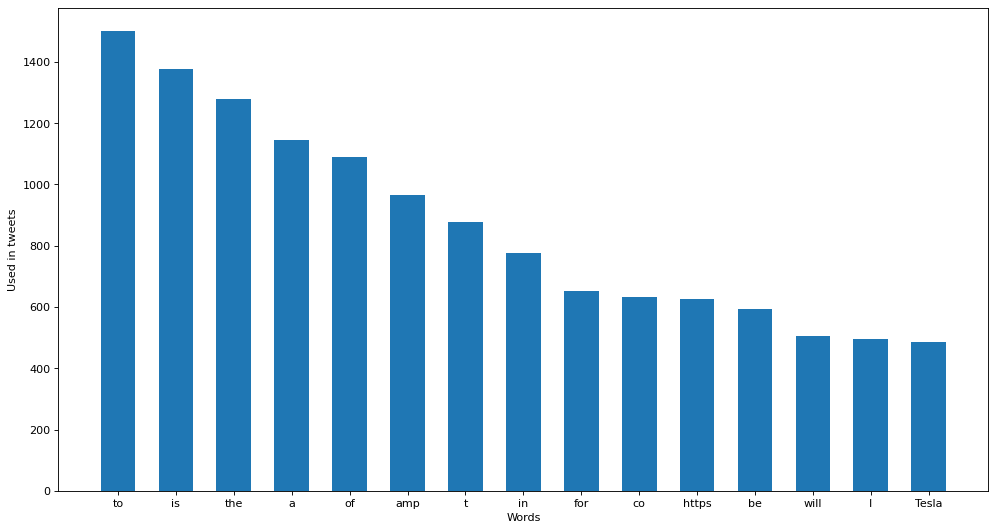

In [10]:

# we don't want to print all words yet, so let's have a look at 30 of them first
df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()



# Improving data quality

 We need to improve quality of our data. Let's delete some unimportant words like "the" "a" "is" etc,
 then print once again

- It is also a good idea to save words_in_tweets to pandas.dataFrame.
- We need to use the field *.created_at* in every tweet we are interested in (*downloaded_tweets*).


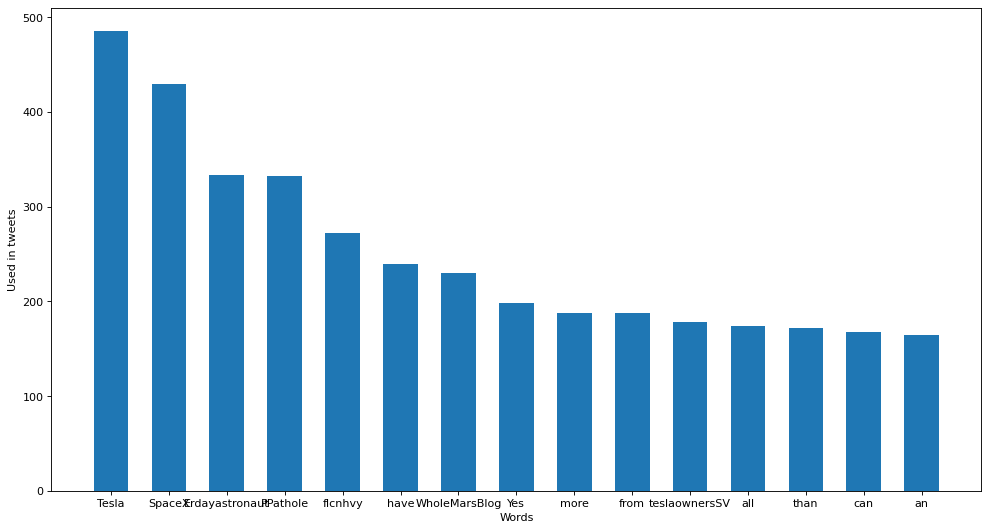

In [11]:

unimportant_words = ['the' ,'a', 'to', 'is', 't', 'of',
                     'be', 'will', 'that', 'this', 'https',
                     'co', 'on', 'we', 'with', 'so', 'for',
                     'at', 'but', 's', 'you', 'was', 'in',
                     'it', 'I', 'or', 'year', 'as', 'are',
                     'no', 'not', 'with', 'This', 'It', 'much',
                     'We', 'do', 'by', 'just', 'The', 'amp'
                     ]
for word in unimportant_words:
    words_to_work_with.pop(word, None)

df = pandas.DataFrame(words_to_work_with.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()


In [12]:

# saving our dictionary to DataFrame
words_in_tweets_df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])

display(HTML(words_in_tweets_df.head(15).to_html()))

# saving downloaded_tweets into a pandas.DataFrame
# firstly, we need to create list  which will help us putting interesting data in df

temp_list_of_dicts = []
for tweet in downloaded_tweets:
    temp_list_of_dicts.append({'id': tweet.id,
                               'text': tweet.full_text,
                               'date': tweet.created_at})

# FILTERING DATA
downloaded_tweets_df = pandas.DataFrame(temp_list_of_dicts)
downloaded_tweets_df['text'] = downloaded_tweets_df['text'].str.lower()

df_tesla_word = downloaded_tweets_df[downloaded_tweets_df['text'].str.contains('tesla', na=False)]

# we have tweets with words tesla or spacex
print(df_tesla_word.shape)


,word,used
0,Caspar_Stanley,16
1,Erdayastronaut,334
2,SpaceX,430
3,SuperHeavyBN3,2
4,Lot,20
5,of,1088
6,plumbing,2
7,itsALLrisky,32
8,Please,20
9,note,12


(904, 3)



# Downloading historical data of tesla stock prices

Let's check the oldest tweet and download stock data from this day.


In [13]:

# extracting date to string
oldest_tweet_about_tesla_date = str(df_tesla_word.date.iloc[-1])

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split(' ')

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date[0]

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split('-')

# YEAR MONTH DAY
date_tesla = [int(a) for a in oldest_tweet_about_tesla_date]


In [14]:
# importing important libraries
from datetime import datetime
import yfinance as yahoofinance


In [15]:

# downloading dataframe from Yahoo Finance
start_date = datetime(date_tesla[0], date_tesla[1], date_tesla[2])
end_date = datetime.now()
tesla_stock_prices_data = yahoofinance.download('TSLA', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed



# Adjusting and merging Dataframes


In [16]:

temp_DF = df_tesla_word.copy()
temp_DF.reset_index(inplace=True)
tweets_dates_list = []

temp_DF = temp_DF.drop(columns=['index', 'id', 'text'])
for row in temp_DF.date:
    tweets_dates_list.append(str(row).split(' ')[0])

# adjusting dataframe and cleaning data
tweets_dates_DF = pandas.DataFrame(data=tweets_dates_list)
tweets_dates_DF.drop_duplicates(inplace=True)
tweets_dates_DF =  tweets_dates_DF[::-1]
tweets_dates_DF.reset_index(inplace=True)
tweets_dates_DF = tweets_dates_DF.drop(columns=['index'])
tweets_dates_DF.columns = ['Date']

prices_data = tesla_stock_prices_data.copy()
prices_data.reset_index(inplace=True)
# changing TimeStamp to str (because tweets_dates_DF.Date is str)
prices_data['Date']= prices_data['Date'].astype(str)

# merging data to print relevant markers in specific dates, dropping useless columns
inner_merged = pandas.merge(tweets_dates_DF, prices_data)
inner_merged = inner_merged.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])
prices_data = prices_data.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])

display(HTML(inner_merged.head().to_html()))
display(HTML(prices_data.head().to_html()))


,Date,High
0,2020-07-06,275.558014
1,2020-07-07,285.899994
2,2020-07-08,283.451996
3,2020-07-09,281.712006
4,2020-07-10,309.783997


,Date,High
0,2020-07-06,275.558014
1,2020-07-07,285.899994
2,2020-07-08,283.451996
3,2020-07-09,281.712006
4,2020-07-10,309.783997



# Plotting stock prices with tweet days markers


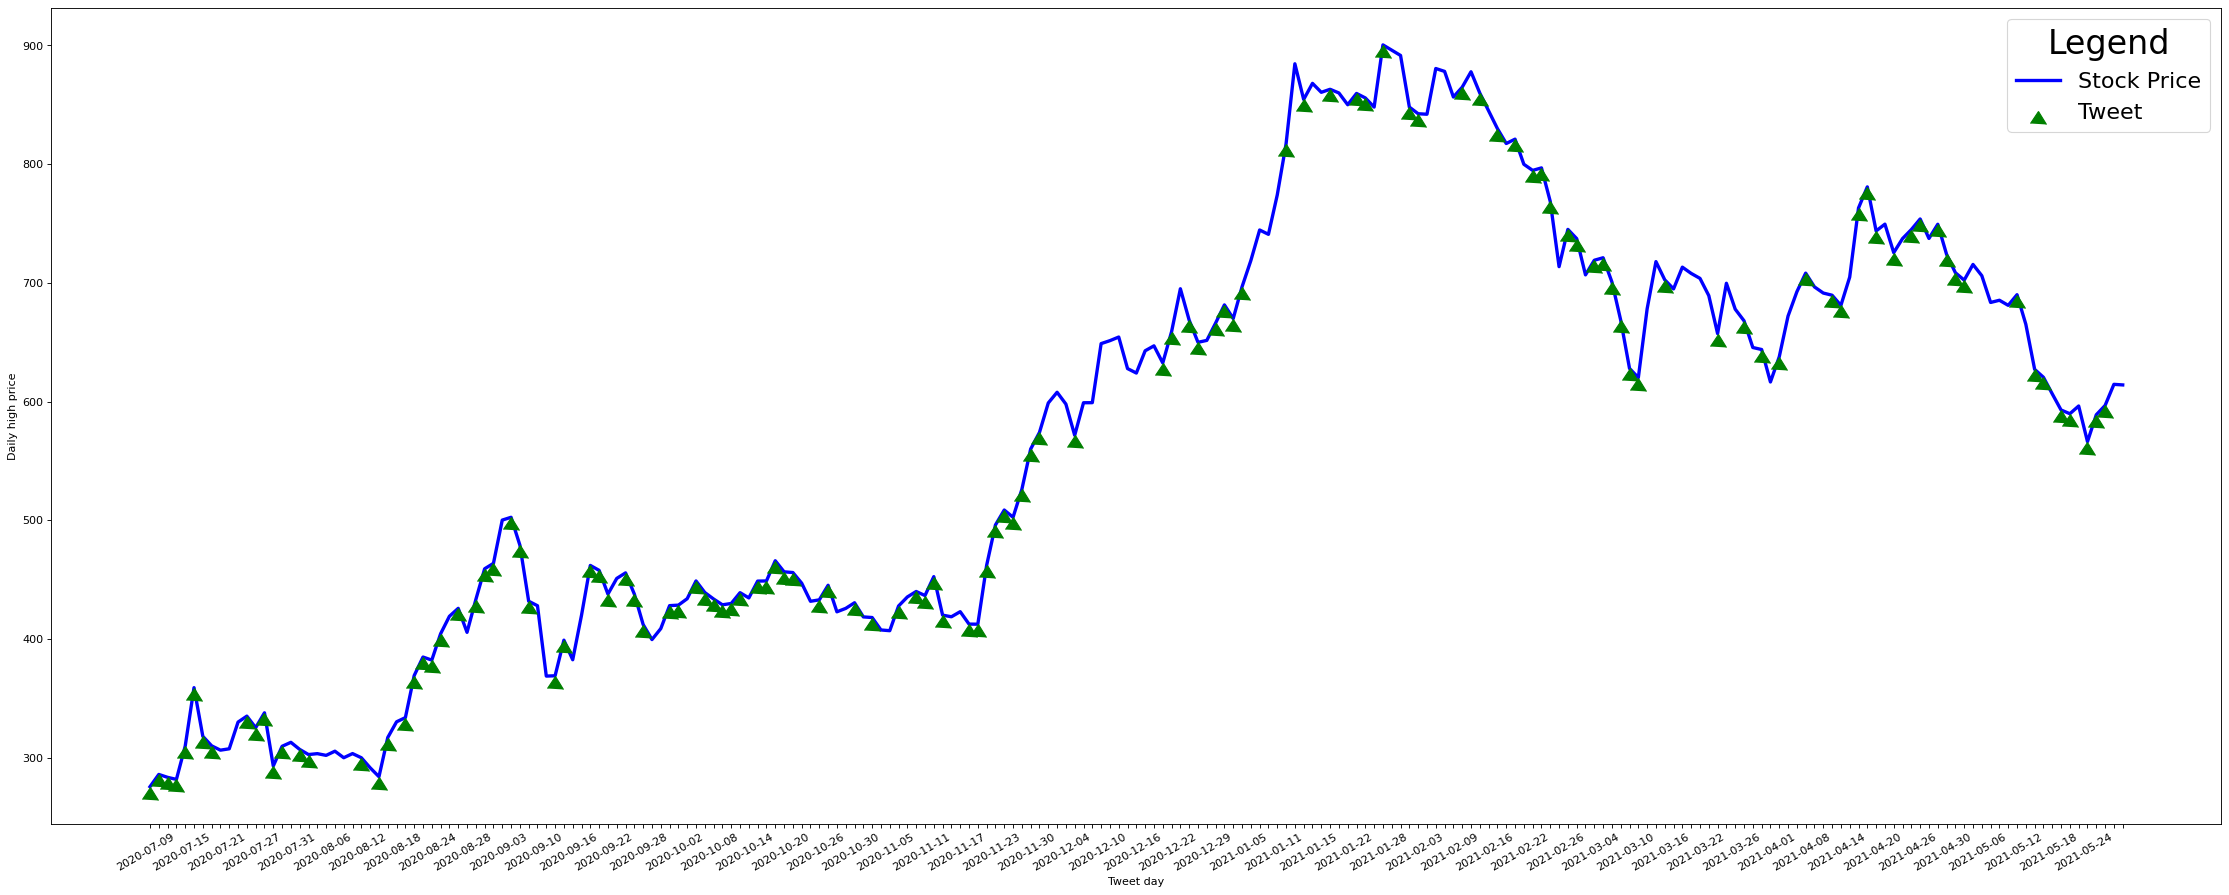

In [17]:

stock_fig = plt.figure(figsize=(35, 15), dpi=80)


stock_price = stock_fig.add_subplot(111)
stock_price.set_xticklabels(prices_data.Date)
stock_price.xaxis_date()
stock_price.plot(prices_data.Date, prices_data.High,
                 color='b', label='Stock Price', linewidth=3
                 )
stock_price.set_ylabel('Daily high price')
stock_price.set_xlabel('Date')

musk_twitter_act = stock_fig.add_subplot(111)
musk_twitter_act.xaxis_date()
musk_twitter_act.plot(inner_merged.Date, inner_merged.High,
                      marker=6, color='g', linestyle = 'None',
                      markersize=15, label='Tweet'
                      )
musk_twitter_act.set_xlabel('Tweet day')

# hiding every second x_label TWICE (to get 1/4 of original number of labels) to improve visibility
for label in stock_price.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for label in stock_price.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

stock_fig.autofmt_xdate()
plt.legend(title="Legend", fontsize=20, title_fontsize=30)
plt.show()



# First analysis

At this point we can draw some conclusions, but firstly - let's think about the correlation between the tweet and the
stock price.
To explore this we can check some of financial indicators used in technical analysis like **moving average**.

### What is a moving average?
A moving average is a statistic that captures the average change in a data series over time.
In finance, moving averages are often used by technical analysts to keep track of prices trends for specific securities.
An upward trend in a moving average might signify an upswing in the price or momentum of a security,
while a downward trend would be seen as a sign of decline.


### What we can explore using a moving average?
Generally, technical analysts will use moving averages to detect whether a change in **momentum** is occurring for
a security. By calculating the moving average, the impacts of random,short-term fluctuations on the price of a stock
over a specified time-frame are mitigated.

We can describe moving average formula as:

\begin{align}
\textit{SMA}_{k} &= \frac{p_{n-k+1} + p_{n-k+2} \cdots + p_{n}}{k} = \frac{1}{k} \sum_{i=n-k+1}^{n} p_{i}
\end{align}


[You can read more about basic financial analysis here](https://www.investopedia.com/terms/m/movingaverage.asp
 "investopedia.com")


In [18]:

# dataframe setup for difference and moving average
prices_data['Difference'] = prices_data.High.diff()
inner_merged.drop('High', inplace=True, axis=1)

# marking tweet day
inner_merged['tweet_day'] = 'tweet'


In [19]:
# merging dataframes to illustrate differences at the tweet days
# showing and calculating moving average for 4 last prices
difference_compared = pandas.merge(prices_data, inner_merged, on='Date', how='outer')
difference_compared['MovingAverage_10'] = difference_compared.iloc[:,1].rolling(window=10).mean()

display(HTML(difference_compared.head(30).to_html()))


,Date,High,Difference,tweet_day,MovingAverage_10
0,2020-07-06,275.558014,NaN,tweet,NaN
1,2020-07-07,285.899994,10.341980,tweet,NaN
2,2020-07-08,283.451996,-2.447998,tweet,NaN
3,2020-07-09,281.712006,-1.739990,tweet,NaN
4,2020-07-10,309.783997,28.071991,tweet,NaN
5,2020-07-13,358.997986,49.213989,tweet,NaN
6,2020-07-14,318.000000,-40.997986,tweet,NaN
7,2020-07-15,310.000000,-8.000000,tweet,NaN
8,2020-07-16,306.342010,-3.657990,NaN,NaN
9,2020-07-17,307.502014,1.160004,NaN,303.724802


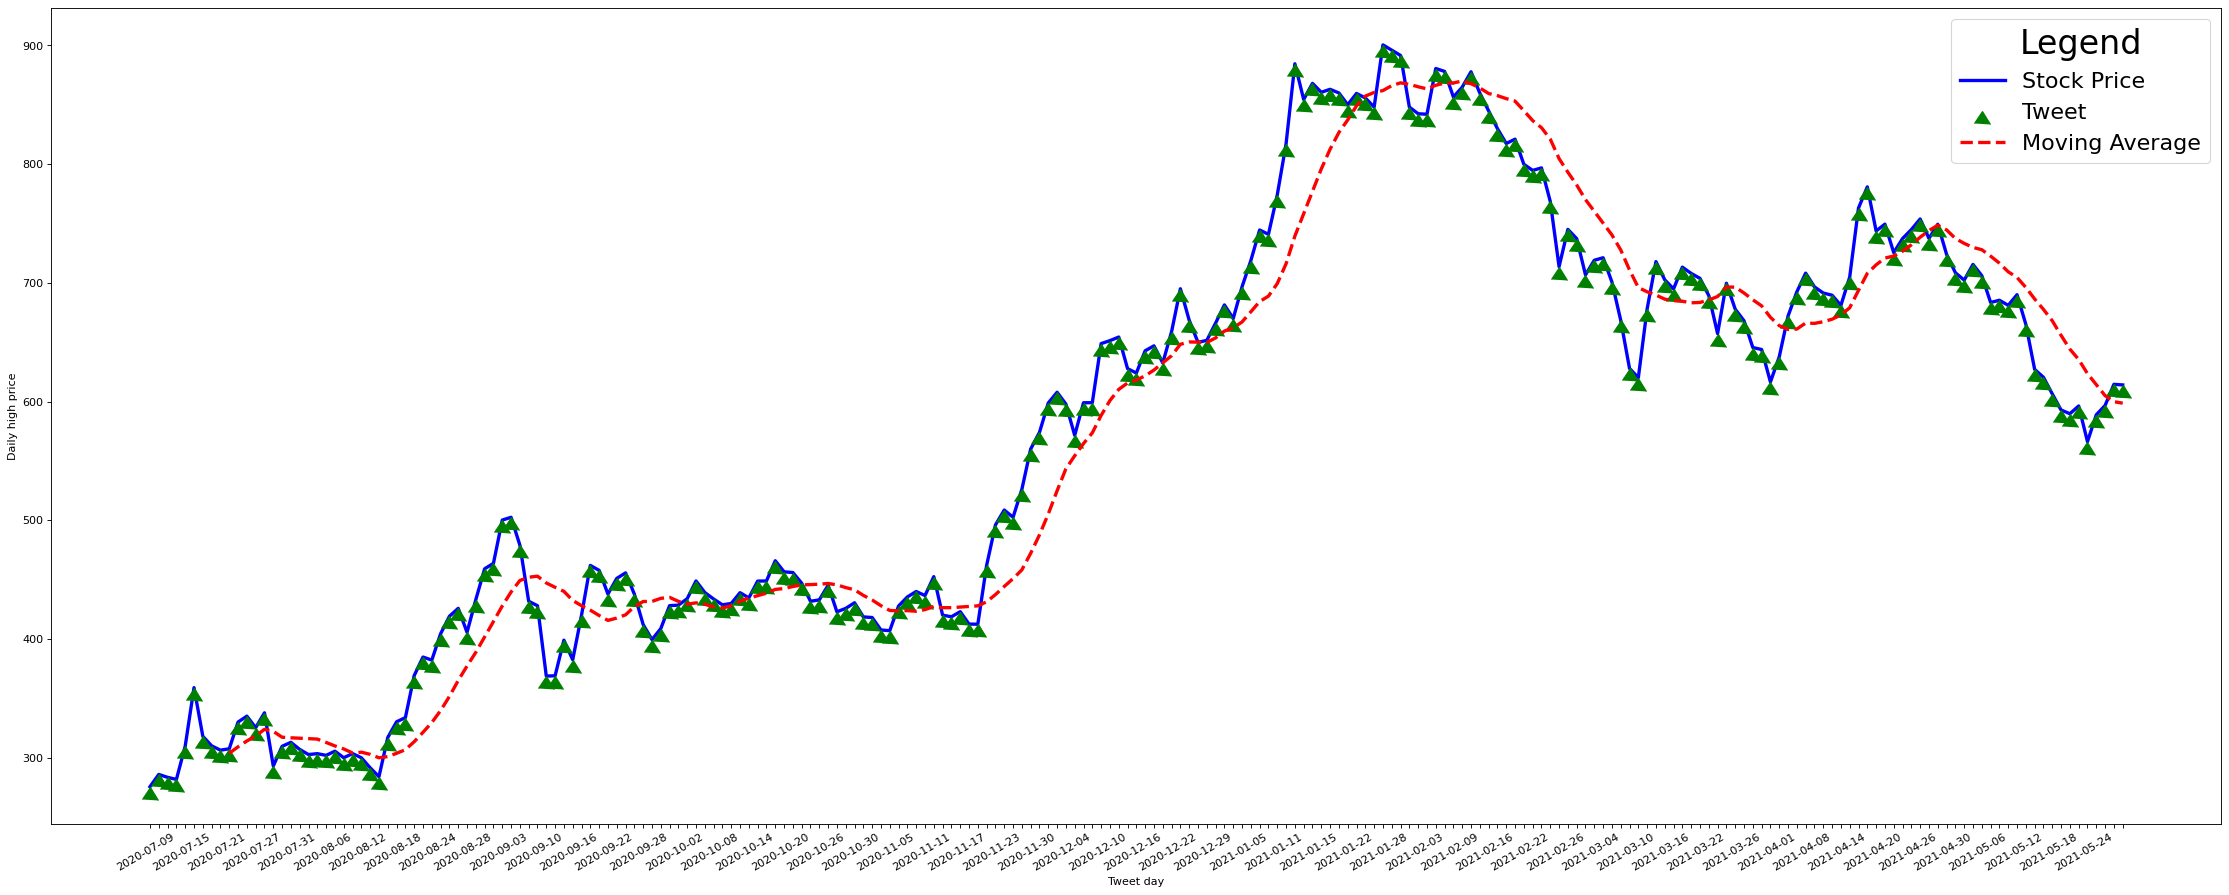

In [20]:

stock_fig = plt.figure(figsize=(35, 15), dpi=80)


stock_price = stock_fig.add_subplot(111)
stock_price.set_xticklabels(prices_data.Date)
stock_price.xaxis_date()
stock_price.plot(prices_data.Date, prices_data.High,
                 color='b', linewidth=3, label='Stock Price'
                 )
stock_price.set_ylabel('Daily high price')
stock_price.set_xlabel('Date')

musk_twitter_act = stock_fig.add_subplot(111)
musk_twitter_act.xaxis_date()
musk_twitter_act.plot(difference_compared.Date, difference_compared.High,
                      marker=6, color='g',
                      linestyle = 'None', markersize=15,
                      label='Tweet'
                      )
musk_twitter_act.set_xlabel('Tweet day')

moving_average = stock_fig.add_subplot(111)
moving_average.xaxis_date()
moving_average.plot(difference_compared.Date, difference_compared.MovingAverage_10,
                    color='r', linestyle='dashed', linewidth=3, label='Moving Average'
                    )

# hiding every second x_label TWICE (to get 1/4 of original number of labels) to improve visibility
for label in stock_price.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for label in stock_price.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

stock_fig.autofmt_xdate()
plt.legend(title="Legend", fontsize=20, title_fontsize=30)
plt.show()


# Statistics is our friend

To learn more about the data we can:
1. Mean
    - Calculate mean of all differences between next stock days
    - Calculate mean of differences at the day after tweet
    - Compare
2. Standard deviation
    - Calculate standard deviation of all differences between next stock days
    - Calculate standard deviation of differences at the day after tweet
    - Compare these two results and draw some conclusions

### Mean

A mean is the mathematical average of a set of two or more numbers, a central value of a finite set of numbers.
In statistics, it is a measure of the central tendency.
The law of large numbers states that the larger the size of the sample,
the more likely it is that the sample mean will be close to the mean.

##### Definition:

\begin{align}
\overline{x} = \frac{1}{n}\left (\sum_{i=1}^n{x_i}\right ) = \frac{x_1+x_2+\cdots +x_n}{n}
\end{align}

[You can read more about mean in finance](https://www.investopedia.com/terms/m/mean.asp "investopedia.com")

### Standard deviation

A standard deviation is a statistic that measures the *dispersion* of a dataset relative to its mean.
The standard deviation is calculated as the square root of variance by determining
each data point's deviation relative to the mean.  If the data points are further from the mean,
there is a higher deviation within the data set; thus, the more spread out the data, the higher the standard deviation.

##### Definition:

\begin{align}
\ s_{N} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(x_i - \bar{x}\right)^2}.
\end{align}

Where:

\begin{align}
x_{i} = Value \ of \ the \ i^{th} \ point \ in \ the \ data \ set
\end{align}


\begin{align}
\overline{x} = The \ mean \ data \ points \ in \  the \ data \ set
\end{align}


\begin{align}
n = The \ number \ of \ the \ data \ set
\end{align}

### Why do *we* need the standard deviation and the mean?

#### Mean

We can use the mean to compare average difference and difference after tweet day.

#### Standard deviation

Standard deviation helps measure volatility, but we need to remember that a lower standard deviation
isn't necessarily preferable.
If the SD of differences after tweets is much higher than the SD of daily differences, we can probably draw some
conclusions about the influence of Elon Musk twitter.

[You can read more about standard deviation in finance](https://www.investopedia.com/terms/s/standarddeviation.asp
 "investopedia.com")

In [21]:
diff_after_tweet_day = []

for row in difference_compared.iterrows():
    if row[1].tweet_day=='tweet':
        diff_after_tweet_day.append(row[1].Difference)

# we need to drop first number because it's NaN
del diff_after_tweet_day[0]
print(diff_after_tweet_day)


[10.34197998046875, -2.447998046875, -1.739990234375, 28.071990966796875, 49.2139892578125, -40.99798583984375, -8.0, 5.0, -9.71600341796875, 12.5159912109375, -44.79998779296875, 16.5880126953125, -5.977996826171875, -4.313995361328125, -3.511993408203125, -7.5, 33.0, 3.524017333984375, 35.4119873046875, 15.608001708984375, -2.579986572265625, 22.197998046875, 6.701995849609375, 27.610015869140625, 25.91998291015625, 4.5780029296875, 2.3499755859375, -23.449981689453125, -47.240020751953125, 0.260009765625, 29.989990234375, 41.94000244140625, -4.149993896484375, -20.0, 4.67999267578125, -17.91998291015625, -25.610015869140625, 19.3499755859375, 0.420013427734375, 14.95001220703125, -9.75, -5.489990234375, -4.860015869140625, 1.1199951171875, 9.100006103515625, 14.149993896484375, 0.1500244140625, 17.009979248046875, -9.329986572265625, -0.6199951171875, 1.20001220703125, 12.279998779296875, 4.739990234375, -0.540008544921875, 20.78997802734375, 4.600006103515625, -3.42999267578125, 15


# Summarization

